# QCNN Model for classifiaction of digit dataset, applying the Quantum SafeML Method
In this notebook, we instantiate a Quantum covnolutional neural network using Qiskit, and fit it to the sklearn toy datase, digits. We then evaluate the performance of these models on given classes for each dataset using the Quantum SafeMl Method of computing the distance metric values between correctly and incorrectly classified targets. This notebook was inttially based on the qiskit machien learning notebook [The Quantum Convolution Neural Network](https://github.com/qiskit-community/qiskit-machine-learning/blob/stable/0.8/docs/tutorials/11_quantum_convolutional_neural_networks.ipynb)

## Importing necessary libraries
We begin by importing all required libraries for this excercise. This includes various tools using qiskit, the IBM quanutm computing library. From here we can import many attrbiutes that will form the Quantum hybrid mdoel that will be cosntructed later.
We also make sure to import libraries for for data preprocessing, including trainsetsplit and one hot enciding.
We also make sure to improt the dataset digits form the sklearn library.

In [1]:
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import logm
import numpy as np
from sklearn.preprocessing import OneHotEncoder

## preprocessing digits dataset
Once encessary libraries have been imported, we now import the digtis data, and ensure it is in the correct format for QCNN operation. 

This entails Reshaping the images. You see, intially the images are 8X8 pixels, but we need to flatten this toa  single dimension of size 64. Once this is compelte, we nromalize the values of theze pixels.

### Principle Componenet analysis
Cosntrained by the limitations of our quanutm simulation, we must consider ways to reduce the stress on our mdoel. A way of doign thsi is PCA, which wuill allow us to find the most signifcant features of our data and focus on these during model fitting.

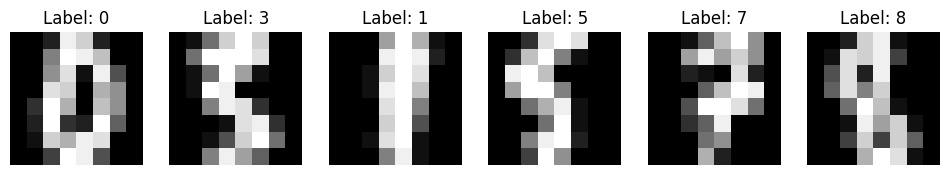

In [4]:
# Load the digits dataset
digits = load_digits()


images = digits.images


# Flatten images into 64 features
digits_flattened = digits.images.reshape((digits.images.shape[0], -1))  # Shape (1797, 64)

# Normalize the dataset (scale between 0 and π)
digits_flattened = (digits_flattened / np.max(digits_flattened)) * np.pi

# Reduce features to fit 6 qubits
from sklearn.decomposition import PCA
pca = PCA(n_components=6)  # Reduce to 6 features
digits_reduced = pca.fit_transform(digits_flattened)  # Shape (1797, 6)

# Labels remain the same
digits_labels = digits.target

labels = digits.target


# Generate a random number of images to display
num_images = random.randint(1, 10)  # Randomly choose between 1 and 10 images
indices = random.sample(range(len(digits.images)), num_images)

# Plot the images
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
if num_images == 1:
    axes = [axes]  # Ensure axes is iterable for single image case

for ax, idx in zip(axes, indices):
    ax.imshow(digits.images[idx], cmap='gray')
    ax.set_title(f"Label: {digits.target[idx]}")
    ax.axis("off")

plt.show()



## Defining layer architectrue for QCNN
Now that our is properly preprocessed, it is time to build our QCNN model erchitecture. Starting wiht the layers, we require two specific types,a  covnolutional layer, which will build the weightings between nodes, and a pooling layer, which will gradually reduce model dimensionality as it moves to output. Both of these layers are parallell to what is found in a classical CNN, but the difference here is using quantum computing principles such as featrue maps and quantum circuits.

In [3]:
algorithm_globals.random_seed = 12345
estimator = Estimator()
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

num_qubits = 6

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

feature_map = ZFeatureMap(num_qubits)
feature_map.decompose().draw("mpl", style="clifford")

feature_map = ZFeatureMap(num_qubits)

ansatz = QuantumCircuit(num_qubits, name="Ansatz")

ansatz.compose(conv_layer(num_qubits, "c1"), list(range(num_qubits)), inplace=True)
ansatz.compose(pool_layer([0, 1, 2], [3, 4, 5], "p1"), list(range(6)), inplace=True)

ansatz.compose(conv_layer(3, "c2"), list(range(3, num_qubits)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2], "p2"), list(range(3, num_qubits)), inplace=True)


# Combining Feature Map and Ansatz
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

num_classes = 10  # Ensure 10 classes

observables = [
    SparsePauliOp.from_list([(f"{'I' * (i % num_qubits)}Z{'I' * (num_qubits - (i % num_qubits) - 1)}", 1)]) 
    for i in range(num_classes)  # Still keeping 10 classes
]


# Updated QNN
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observables,  # Now has 10 observables
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


## Fitting model to data
### Splitting Images
We incorporate the train test split mdoule in order to partition our dataset into training and testing susbsets for the model. 

### One hot encoding labels
We then ensure our labels are one hot encoded in order to ensure objective classes are emasured and no inbetween numbers, ensuring the dtaat is inferred categorically and not numerically when classified.

### constrcuting Classifier
Our Qnn model is passed alogn with all other hyperparamters to cosntruct our classifier model. This is then fit to the training data, and the eprfomance is briefly evaluated.

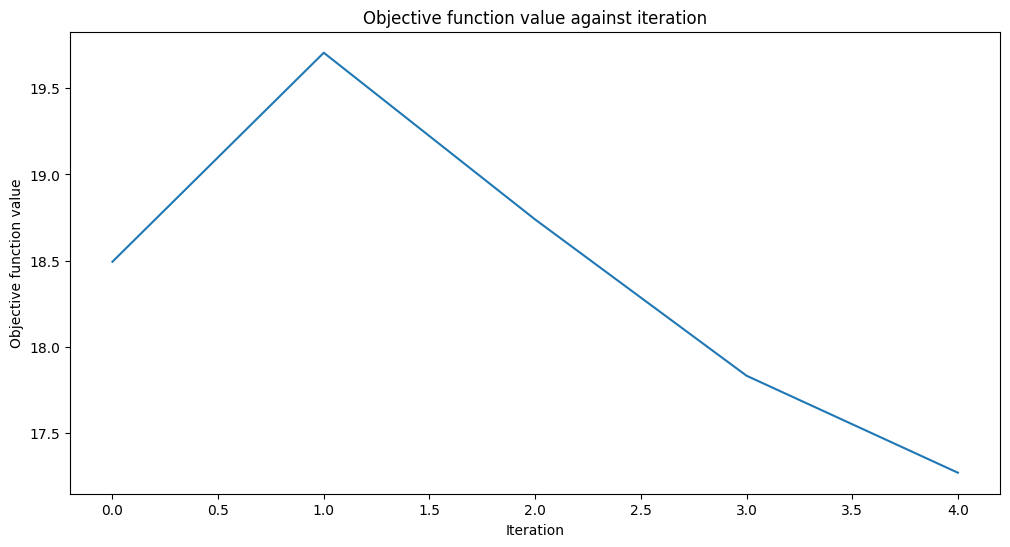

Train Accuracy: 8.70%
Test Accuracy: 7.50%


In [5]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(digits_reduced, digits_labels, test_size=0.2, random_state=42)

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))


# Train QCNN
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=5),
    loss="cross_entropy",  # Ensure multi-class compatibility
    one_hot=True,  # Keep one-hot encoding enabled
    callback=callback_graph,
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Train
classifier.fit(X_train, y_train_encoded)

# Evaluate
train_accuracy = classifier.score(X_train, y_train_encoded)
test_accuracy = classifier.score(X_test, y_test_encoded)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


## Defining sets for the Quantum safeMl Method
Now that our classifier has ran, we now move to applying the quantum safeMl emthod on it's results.

In order to do this, we must take the target class and triangulate tall predictions made to it fromt he classifiwer.

These are then compared against the set of test labels, which contain within them the true classes the targets belong to. A comparison is made to this in order to partition the class predictions into one of two sets. Either correctly predicted into this class, or those incorrectly predicted into this class. The Quantum SafeML method entails applying quantum statistical distance metrics to the two density matrix versions of these sets in order to assess their distinguishability, which in theory represents the confusion the model sees leading to its incorrect predictions. In real implementations, this can be used to notify a human agent if this confusion is above an acceptable threshold. 

In [6]:
# Specify the class you want to analyze
class_id = 2  # Example: class_id 2, you can change this as needed

# Step 1: Get the model predictions
y_pred = classifier.predict(X_test)

# If the predictions are in one-hot encoding (shape: (360, 10)), convert them to class indices
y_pred_class = np.argmax(y_pred, axis=1)

# Step 2: Find all the indices where the true label is equal to the class_id
correct_indices = np.where((y_test == class_id) & (y_pred_class == class_id))[0]
wrong_indices = np.where((y_test == class_id) & (y_pred_class != class_id))[0]

# Step 3: Get the correct and wrong predictions for the chosen class
correct_predictions = X_test[correct_indices]
wrong_predictions = X_test[wrong_indices]

# Example output
print(f"Number of correct predictions for class {class_id}: {len(correct_predictions)}")
print(f"Number of wrong predictions for class {class_id}: {len(wrong_predictions)}")

# Optionally, print or return these predictions for further use
#print("Correct predictions for class {class_id}: ", correct_predictions)
#print("Wrong predictions for class {class_id}: ", wrong_predictions)



Number of correct predictions for class 2: 2
Number of wrong predictions for class 2: 31


## Defining distance metrics
The initial Quantum SafeML method will employ 4 known quantum distance metrics for evaluation. These are trace distance, Bures distance, quantum relative entropy, and fidelity, respectively. Functions are made for each of these metrics, which take the argument of two density matrices on which they will compute. After adequate safety checks are made relating to the shape of these matrices, the functions return a result.

In [10]:
def bures_distance(rho1, rho2):
    """Compute the Bures distance between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure matrices are Hermitian (conjugate transpose equals the matrix)
    rho1 = np.array(rho1, dtype=complex)
    rho2 = np.array(rho2, dtype=complex)
    
    sqrt_rho1 = sqrtm(rho1 + 1e-10 * np.eye(rho1.shape[0]))  # Add small noise for stability
    intermediate = sqrt_rho1 @ rho2 @ sqrt_rho1
    sqrt_intermediate = sqrtm(intermediate)
    fidelity_value = np.real(np.trace(sqrt_intermediate)) ** 2
    bures_dist = np.sqrt(2 * (1 - np.sqrt(fidelity_value)))
    
    return bures_dist

def fidelity(rho1, rho2):
    """Compute the fidelity between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure matrices are Hermitian (conjugate transpose equals the matrix)
    rho1 = np.array(rho1, dtype=complex)
    rho2 = np.array(rho2, dtype=complex)
    
    sqrt_rho1 = sqrtm(rho1)
    sqrt_rho2 = sqrtm(rho2)
    fidelity_value = np.real(np.trace(sqrt_rho1 @ sqrt_rho2))**2

    return fidelity_value

def trace_distance(rho1, rho2):
    """Compute the trace distance between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure matrices are Hermitian (conjugate transpose equals the matrix)
    rho1 = np.array(rho1, dtype=complex)
    rho2 = np.array(rho2, dtype=complex)

    trace_dist = 0.5 * np.trace(np.abs(rho1 - rho2))
    
    return trace_dist
def quantum_relative_entropy(rho1, rho2):
    """Compute the quantum relative entropy between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure the matrices are positive semidefinite and well-conditioned
    if np.any(np.linalg.eigvals(rho1) < 0) or np.any(np.linalg.eigvals(rho2) < 0):
       # raise ValueError("The input density matrices must be positive semidefinite.")
        return 1
        
    # Calculate the logarithms of the density matrices
    log_rho1 = logm(rho1)
    log_rho2 = logm(rho2)

    relative_entropy = np.trace(rho1 @ (log_rho1 - log_rho2))

    return relative_entropy

## COnverting prediction sets into density matrices
the created sets must now be converted into  the correct format for calculation, that being the density matrix. First we Define a function for this, that ensures forrect shapes for the set.

upon compeltion of this conversion, the distance emtrics are employed
                                                                                                                                                                                

In [12]:
def create_density_matrix(data):
    """Convert feature vectors into a density matrix."""
    if data.shape[0] < 2:  # Check if there's at least 2 samples
        print("Warning: Not enough data points to compute covariance. Returning identity matrix.")
        return np.eye(data.shape[1])  # Return identity matrix of appropriate size

    cov_matrix = np.cov(data, rowvar=False)  # Covariance matrix
    trace = np.trace(cov_matrix)
    
    if trace == 0:  # Avoid division by zero
        print("Warning: Trace is zero. Returning identity matrix.")
        return np.eye(data.shape[1])

    density_matrix = cov_matrix / trace  # Normalize trace to 1
    return density_matrix

# Convert to density matrices
if correct_predictions.size > 0:
    rho1 = create_density_matrix(correct_predictions)
else:
    rho1 = np.eye(X_test.shape[1])  # Return identity if no correct predictions

if wrong_predictions.size > 0:
    rho2 = create_density_matrix(wrong_predictions)
else:
    rho2 = np.eye(X_test.shape[1])  # Return identity if no wrong predictions

# Ensure same shape (truncate to smaller size)
min_dim = min(rho1.shape[0], rho2.shape[0])
rho1 = rho1[:min_dim, :min_dim]
rho2 = rho2[:min_dim, :min_dim]

print("Density matrices created successfully!")


# Convert to density matrices
#rho1 = create_density_matrix(correct_predictions)
#rho2 = create_density_matrix(wrong_predictions)

# Ensure same shape (truncate to smaller size)
min_dim = min(rho1.shape[0], rho2.shape[0])
rho1 = rho1[:min_dim, :min_dim]
rho2 = rho2[:min_dim, :min_dim]
accuracy = classifier.score(X_test, y_test_encoded)

print("metric results on the Dataset")
print("Bures distance:", bures_distance(rho1, rho2))
print("Trace distance:", trace_distance(rho1, rho2))
print("Fidelity:", fidelity(rho1, rho2))
print("Relative entropy:", quantum_relative_entropy(rho1, rho2))
print("True Accuracy:", accuracy)

Density matrices created successfully!
metric results on the Dataset
Bures distance: 1.174871585320293
Trace distance: 0.49399409305540143
Fidelity: 0.09252441752373392
Relative entropy: 1
True Accuracy: 0.08611111111111111


## Comparing metric values across the dataset classes
Now we add further secruity to our matrix conversions and traverse through each class in the dataset, performing out metric calculations on each. We view how these values, once normalized, vary through the diffrent labels.

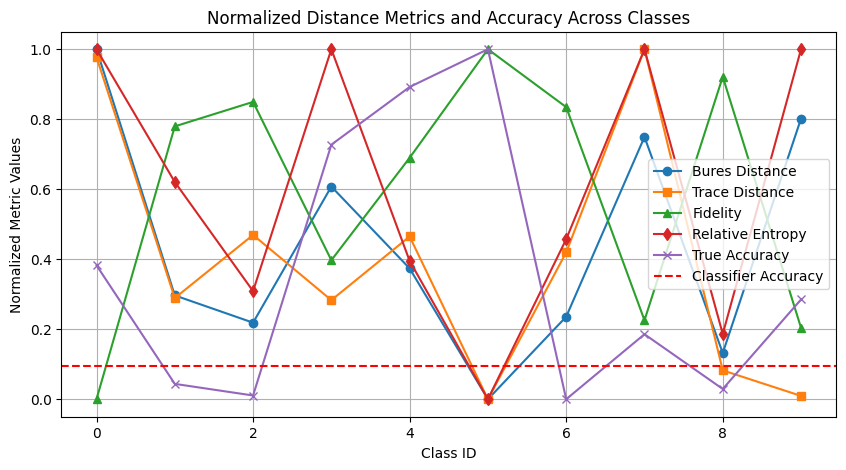

In [13]:
# Step 1: Get the model predictions
y_pred = classifier.predict(X_test)

# If predictions are in one-hot encoding, convert them to class indices
y_pred_class = np.argmax(y_pred, axis=1)

# Get unique class labels
unique_classes = np.unique(y_test)

# Initialize lists to store results
bures_distances = []
trace_distances = []
fidelities = []
relative_entropies = []
accuracies = []

def compute_density_matrix(data):
    if len(data) == 0:
        return np.zeros((X_test.shape[1], X_test.shape[1]))  # Return zero matrix if empty
    elif len(data) == 1:
        return np.eye(X_test.shape[1]) / X_test.shape[1]  # Return identity matrix if only one sample
    covariance_matrix = np.cov(data, rowvar=False)  # Compute covariance matrix
    if covariance_matrix.ndim == 1:
        covariance_matrix = np.expand_dims(covariance_matrix, axis=0)  # Ensure it's 2D
    return covariance_matrix / np.trace(covariance_matrix)  # Normalize to make it a density matrix

# Step 2: Compute metrics for each class
for class_id in unique_classes:
    correct_indices = np.where((y_test == class_id) & (y_pred_class == class_id))[0]
    wrong_indices = np.where((y_test == class_id) & (y_pred_class != class_id))[0]
    
    correct_predictions = X_test[correct_indices]
    wrong_predictions = X_test[wrong_indices]
    
    # Convert to density matrices
    rho1 = compute_density_matrix(correct_predictions)
    rho2 = compute_density_matrix(wrong_predictions)
    
    # Compute metrics
    bures_distances.append(bures_distance(rho1, rho2))
    trace_distances.append(trace_distance(rho1, rho2))
    fidelities.append(fidelity(rho1, rho2))
    relative_entropies.append(quantum_relative_entropy(rho1, rho2))
    accuracies.append(len(correct_indices) / (len(correct_indices) + len(wrong_indices)))

# Normalize metric values to [0,1] range
def normalize(values):
    min_val, max_val = min(values), max(values)
    return [(v - min_val) / (max_val - min_val) if max_val > min_val else 0 for v in values]

bures_distances = normalize(bures_distances)
trace_distances = normalize(trace_distances)
fidelities = normalize(fidelities)
relative_entropies = normalize(relative_entropies)
accuracies = normalize(accuracies)

# Compute overall classifier accuracy
classifier_accuracy = np.mean(y_pred_class == y_test)

# Step 3: Plot the results
plt.figure(figsize=(10, 5))
plt.plot(unique_classes, bures_distances, marker='o', label='Bures Distance')
plt.plot(unique_classes, trace_distances, marker='s', label='Trace Distance')
plt.plot(unique_classes, fidelities, marker='^', label='Fidelity')
plt.plot(unique_classes, relative_entropies, marker='d', label='Relative Entropy')
plt.plot(unique_classes, accuracies, marker='x', label='True Accuracy')

# Add classifier accuracy as a dotted horizontal line
plt.axhline(y=classifier_accuracy, color='r', linestyle='--', label='Classifier Accuracy')

plt.xlabel("Class ID")
plt.ylabel("Normalized Metric Values")
plt.title("Normalized Distance Metrics and Accuracy Across Classes")
plt.legend()
plt.grid()
plt.show()

C:\Users\olive\AppData\Local\Temp\ipykernel_22348\4237316504.py:58: RuntimeWarning: logm result may be inaccurate, approximate err = inf
  log_rho1 = logm(rho1)


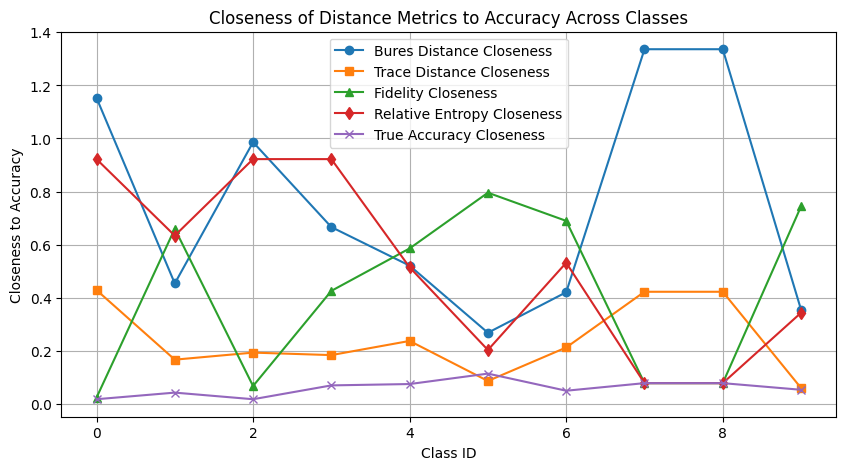

In [33]:
# Step 1: Get the model predictions
y_pred = classifier.predict(X_test)

# If predictions are in one-hot encoding, convert them to class indices
y_pred_class = np.argmax(y_pred, axis=1)

# Get unique class labels
unique_classes = np.unique(y_test)

# Initialize lists to store results
bures_distances = []
trace_distances = []
fidelities = []
relative_entropies = []
accuracies = []

def compute_density_matrix(data):
    if len(data) == 0:
        return np.zeros((X_test.shape[1], X_test.shape[1]))  # Return zero matrix if empty
    elif len(data) == 1:
        return np.eye(X_test.shape[1]) / X_test.shape[1]  # Return identity matrix if only one sample
    covariance_matrix = np.cov(data, rowvar=False)  # Compute covariance matrix
    if covariance_matrix.ndim == 1:
        covariance_matrix = np.expand_dims(covariance_matrix, axis=0)  # Ensure it's 2D
    return covariance_matrix / np.trace(covariance_matrix)  # Normalize to make it a density matrix

# Step 2: Compute metrics for each class
for class_id in unique_classes:
    correct_indices = np.where((y_test == class_id) & (y_pred_class == class_id))[0]
    wrong_indices = np.where((y_test == class_id) & (y_pred_class != class_id))[0]
    
    correct_predictions = X_test[correct_indices]
    wrong_predictions = X_test[wrong_indices]
    
    # Convert to density matrices
    rho1 = compute_density_matrix(correct_predictions)
    rho2 = compute_density_matrix(wrong_predictions)
    
    # Compute metrics
    bures_distances.append(bures_distance(rho1, rho2))
    trace_distances.append(trace_distance(rho1, rho2))
    fidelities.append(fidelity(rho1, rho2))
    relative_entropies.append(quantum_relative_entropy(rho1, rho2))
    accuracies.append(len(correct_indices) / (len(correct_indices) + len(wrong_indices)))

# Compute overall classifier accuracy
classifier_accuracy = np.mean(y_pred_class == y_test)

# Compute closeness to accuracy for each metric
def closeness_to_accuracy(values):
    return [abs(v - classifier_accuracy) for v in values]

bures_closeness = closeness_to_accuracy(bures_distances)
trace_closeness = closeness_to_accuracy(trace_distances)
fidelity_closeness = closeness_to_accuracy(fidelities)
relative_entropy_closeness = closeness_to_accuracy(relative_entropies)
accuracy_closeness = closeness_to_accuracy(accuracies)

# Step 3: Plot closeness to accuracy
plt.figure(figsize=(10, 5))
plt.plot(unique_classes, bures_closeness, marker='o', label='Bures Distance Closeness')
plt.plot(unique_classes, trace_closeness, marker='s', label='Trace Distance Closeness')
plt.plot(unique_classes, fidelity_closeness, marker='^', label='Fidelity Closeness')
plt.plot(unique_classes, relative_entropy_closeness, marker='d', label='Relative Entropy Closeness')
plt.plot(unique_classes, accuracy_closeness, marker='x', label='True Accuracy Closeness')

plt.xlabel("Class ID")
plt.ylabel("Closeness to Accuracy")
plt.title("Closeness of Distance Metrics to Accuracy Across Classes")
plt.legend()
plt.grid()
plt.show()

## heatmap showing metric closeness to accurayc across the different ataaset classes

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\linalg\_matfuncs.py:202: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)
C:\Users\olive\AppData\Local\Temp\ipykernel_22348\4237316504.py:58: RuntimeWarning: logm result may be inaccurate, approximate err = inf
  log_rho1 = logm(rho1)


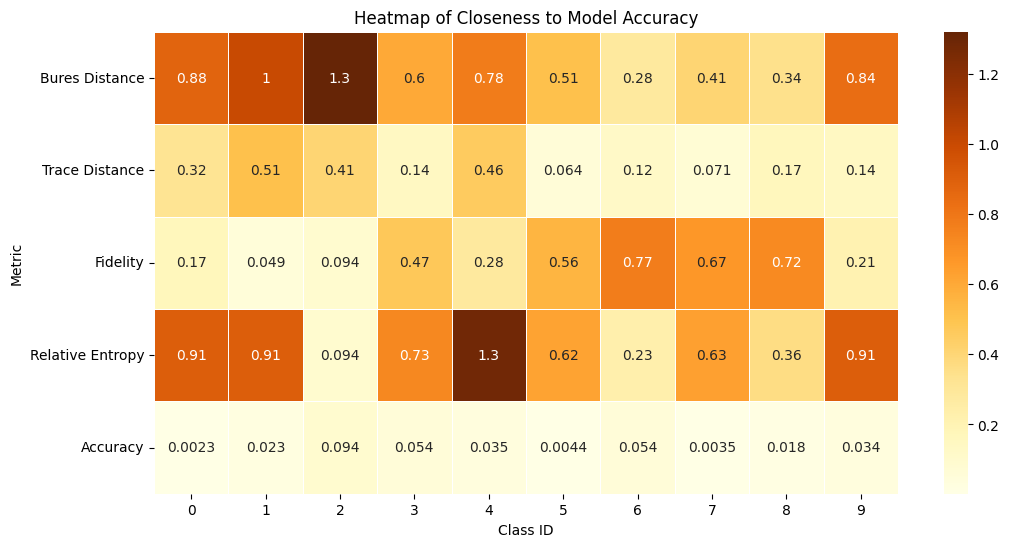

In [43]:
# Assume functions bures_distance, trace_distance, fidelity, and quantum_relative_entropy are defined

def compute_density_matrix(data):
    if len(data) == 0:
        return np.zeros((X_test.shape[1], X_test.shape[1]))
    elif len(data) == 1:
        return np.eye(X_test.shape[1]) / X_test.shape[1]
    covariance_matrix = np.cov(data, rowvar=False)
    if covariance_matrix.ndim == 1:
        covariance_matrix = np.expand_dims(covariance_matrix, axis=0)
    return covariance_matrix / np.trace(covariance_matrix)

# Get model predictions
y_pred = classifier.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
unique_classes = np.unique(y_test)

# Storage for metric values
metric_values = {
    "Bures Distance": [],
    "Trace Distance": [],
    "Fidelity": [],
    "Relative Entropy": [],
    "Accuracy": []
}

classifier_accuracy = np.mean(y_pred_class == y_test)

for class_id in unique_classes:
    correct_indices = np.where((y_test == class_id) & (y_pred_class == class_id))[0]
    misclassified_indices = np.where((y_test != class_id) & (y_pred_class == class_id))[0]
    
    correct_predictions = X_test[correct_indices]
    misclassified_as_class = X_test[misclassified_indices]
    
    rho_correct = compute_density_matrix(correct_predictions)
    rho_misclassified = compute_density_matrix(misclassified_as_class)
    
    # Compute metrics
    metric_values["Bures Distance"].append(bures_distance(rho_correct, rho_misclassified))
    metric_values["Trace Distance"].append(trace_distance(rho_correct, rho_misclassified))
    metric_values["Fidelity"].append(fidelity(rho_correct, rho_misclassified))
    metric_values["Relative Entropy"].append(quantum_relative_entropy(rho_correct, rho_misclassified))
    metric_values["Accuracy"].append(len(correct_indices) / (len(correct_indices) + len(misclassified_indices) + 1e-6))

# Compute closeness to classifier accuracy
for key in metric_values:
    metric_values[key] = np.abs(np.array(metric_values[key]) - classifier_accuracy)

# Convert to a matrix for heatmap
data_matrix = np.array([metric_values[key] for key in metric_values])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data_matrix, annot=True, cmap="YlOrBr", xticklabels=unique_classes, yticklabels=metric_values.keys(), linewidths=0.5, vmin=np.min(data_matrix), vmax=np.max(data_matrix))
plt.xlabel("Class ID")
plt.ylabel("Metric")
plt.title("Heatmap of Closeness to Model Accuracy")
plt.show()
